# Import modules

In [1]:
import os
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/tissueaxis.py")
tissueaxis = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = tissueaxis
spec.loader.exec_module(tissueaxis)

In [4]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [5]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# Functions

In [6]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

# Read in adata

* Only OCT sections, for consistency

In [7]:
adata_oct_healthy = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_raw.h5ad')
print(adata_oct_healthy.shape)
adata_oct_healthy_LV = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-LV_foetal_raw.h5ad')
print(adata_oct_healthy_LV.shape)

(14261, 33538)
(6767, 33538)


In [8]:
# concatenate oct adata
adata_oct = adata_oct_healthy.concatenate(
    [adata_oct_healthy_LV],
    batch_key=None,
    index_unique=None,
    join="inner"
)

In [9]:
# log-normalise
sc.pp.normalize_total(adata_oct, target_sum=1e4)
sc.pp.log1p(adata_oct)

# sc.pp.normalize_total(adata_ffpe, target_sum=1e4)
# sc.pp.log1p(adata_ffpe)

# reset var_names
adata_oct.var.set_index('SYMBOL',inplace=True)
# adata_ffpe.var.set_index('SYMBOL',inplace=True)

# Add axis

In [10]:
!ls /nfs/team205/heart/visium_axis/foetal/transmural_LV

BHF_F_Hea13295830.csv	HCAHeartST10317186.csv	HCAHeartST13162330.csv
BHF_F_Hea13295831.csv	HCAHeartST11605165.csv	HCAHeartST13162331.csv
HCAHeartST10317184.csv	HCAHeartST11605167.csv	HCAHeartST13162336.csv
HCAHeartST10317185.csv	HCAHeartST11605168.csv


In [11]:
# add
oct_samples = list(set(adata_oct.obs['sample']))

adata_oct.obs['transmural_axis'] = np.nan

axis_files = os.listdir('/nfs/team205/heart/visium_axis/foetal/transmural_LV')
for file in axis_files:
    # read in
    axis = pd.read_csv(f'/nfs/team205/heart/visium_axis/foetal/transmural_LV/{file}',index_col=0)
    # add to anndata
    if file.split('.csv')[0] in oct_samples:
        adata_oct.obs.loc[axis.index,'transmural_axis'] = axis.copy()

# select spots with axis
adata_oct = adata_oct[adata_oct.obs['transmural_axis'].isna()==False]

In [12]:
# make bin
adata_oct.obs['transmural_axis_bin'] = pd.cut(adata_oct.obs['transmural_axis'],bins=15)

In [13]:
# annotate bin, OCT
adata_oct.obs['tm_bin_annotations'] = adata_oct.obs['transmural_axis_bin'].astype('str').copy()
adata_oct.obs.replace({'tm_bin_annotations':{
    '(-1.002, -0.867]':'outer',
    '(-0.867, -0.733]':'outer',
    '(-0.733, -0.6]':'outer',
    '(-0.6, -0.467]':'outer',
    '(-0.467, -0.333]':'outer',
    '(-0.333, -0.2]':'middle',
    '(-0.2, -0.0667]':'middle',
    '(-0.0667, 0.0667]':'middle',
    '(0.0667, 0.2]':'middle',
    '(0.2, 0.333]':'middle',
    '(0.333, 0.467]':'inner',
    '(0.467, 0.6]':'inner',
    '(0.6, 0.733]':'inner',
    '(0.733, 0.867]':'inner',
    '(0.867, 1.0]':'inner',
}}, inplace=True)

set(adata_oct.obs['tm_bin_annotations'])

{'inner', 'middle', 'outer'}

# Differential test

In [14]:
# mean value per group
group_mean_val = utils.grouped_obs_mean(adata_oct, group_key='tm_bin_annotations')
# DE test
sc.tl.rank_genes_groups(adata_oct, 'tm_bin_annotations', method='t-test')
res = sc.get.rank_genes_groups_df(adata_oct, group=None, pval_cutoff=0.05)
# add mean gene expression
df = group_mean_val.reset_index().melt(id_vars=['SYMBOL'])
df.rename(columns={'SYMBOL':'names','variable':'group','value':'mean_gene_exp'},
          inplace=True)
diff_res = res.merge(df, how='left', on=['group','names'])
diff_res.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,mean_gene_exp
0,inner,MYOM2,62.621651,2.969012,0.0,0.0,1.325198
1,inner,NPPA,61.117050,1.790190,0.0,0.0,4.691978
2,inner,ACTA1,46.915936,3.156108,0.0,0.0,1.818363
3,inner,IRX3,44.479111,1.871265,0.0,0.0,1.122766
4,inner,CRNDE,42.422626,1.734674,0.0,0.0,1.127202


<Axes: xlabel='logfoldchanges', ylabel='mean_gene_exp'>

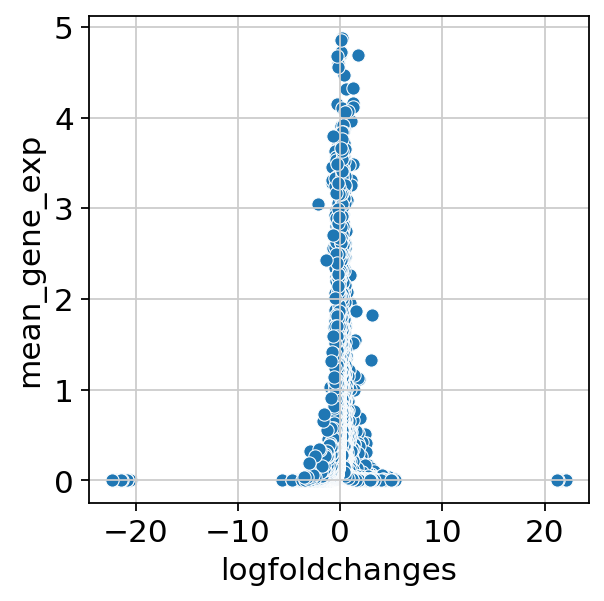

In [15]:
sns.scatterplot(data=diff_res, x='logfoldchanges',y='mean_gene_exp')

<Axes: xlabel='scores', ylabel='mean_gene_exp'>

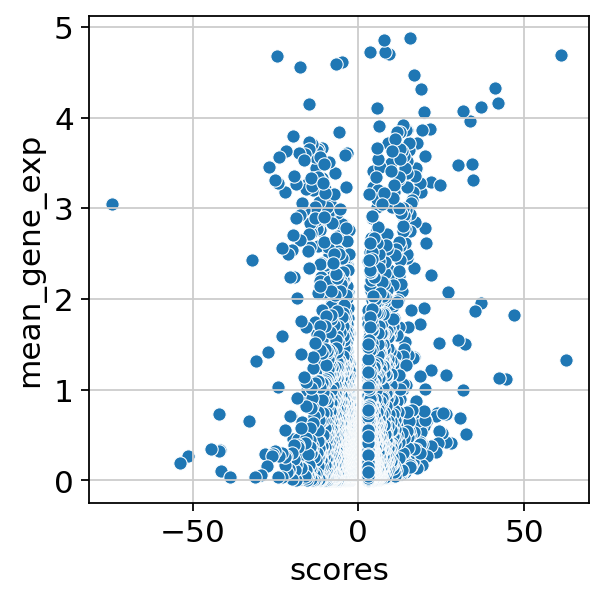

In [16]:
sns.scatterplot(data=diff_res, x='scores',y='mean_gene_exp')

# Slect genes to plot

In [17]:
groups = ['outer','middle','inner']
logfc_thresh = 0.1
mean_exp_thresh = 0.05

gene_lists = {}
for grp in groups:
    gene_lists[f'{grp}_up'] = np.nan
    gene_lists[f'{grp}_down'] = np.nan

In [18]:
display(diff_res[diff_res['names']=='NRG1'])

,group,names,scores,logfoldchanges,pvals,pvals_adj,mean_gene_exp
358,inner,NRG1,7.221292,2.908145,6.942348e-13,3.761429e-11,0.023899
4307,middle,NRG1,-4.377378,-1.542786,1.233876e-05,1.567490e-03,0.004946
8007,outer,NRG1,-7.549096,-3.101157,5.397816e-14,3.333922e-12,0.002035


In [19]:
groups

['outer', 'middle', 'inner']

In [20]:
for grp in groups:
    # up genes
    genes = diff_res[(diff_res['group']==grp)&\
                (diff_res['logfoldchanges'] > logfc_thresh)&\
                (diff_res['mean_gene_exp'] > mean_exp_thresh)
               ]['names']
    gene_lists[f'{grp}_up'] = list(genes)
    print(f"{grp}_up: {len(gene_lists[f'{grp}_up'])}")

    # down genes
    genes = diff_res[(diff_res['group']==grp)&\
                (diff_res['logfoldchanges'] < -logfc_thresh)
                # (res['mean_gene_exp'] > mean_exp_thresh)
               ]['names']
    gene_lists[f'{grp}_down'] = list(genes)
    print(f"{grp}_down: {len(gene_lists[f'{grp}_down'])}")

outer_up: 837
outer_down: 2790
middle_up: 151
middle_down: 373
inner_up: 2447
inner_down: 1187


In [21]:
gene_lists.keys()

dict_keys(['outer_up', 'outer_down', 'middle_up', 'middle_down', 'inner_up', 'inner_down'])

# Pathway analysis

##### outer_up #####
MSigDB_Hallmark_2020


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
0,MSigDB_Hallmark_2020,Hypoxia,51/200,4.237225e-26,2.118612e-24,0,0,8.280086,483.749985,CDKN1C;ERO1A;CDKN1A;CITED2;SLC2A1;ADM;RORA;SLC...,51
1,MSigDB_Hallmark_2020,Myc Targets V1,41/200,1.699656e-17,4.249140e-16,0,0,6.156285,237.715822,YWHAE;HDDC2;HDAC2;SET;HSP90AB1;RPL34;GLO1;RPLP...,41
2,MSigDB_Hallmark_2020,mTORC1 Signaling,32/200,6.422285e-11,1.070381e-09,0,0,4.494528,105.480565,ERO1A;CDKN1A;SLC2A1;STC1;PLOD2;AK4;SLC2A3;ENO1...,32
3,MSigDB_Hallmark_2020,Glycolysis,29/200,5.245969e-09,6.557461e-08,0,0,3.986220,76.000490,ERO1A;CITED2;SDC2;STC1;PLOD2;AK4;ENO1;PYGL;LDH...,29
4,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,26/200,2.986692e-07,2.986692e-06,0,0,3.498689,52.564056,CDKN1A;TNFAIP8;PFKFB3;SLC2A3;ICAM1;NFIL3;NAMPT...,26
6,MSigDB_Hallmark_2020,Estrogen Response Early,25/200,1.055114e-06,6.594461e-06,0,0,3.340605,45.972948,SLC2A1;ADCY1;PRSS23;AFF1;CYP26B1;PODXL;STC2;AL...,25
7,MSigDB_Hallmark_2020,Estrogen Response Late,25/200,1.055114e-06,6.594461e-06,0,0,3.340605,45.972948,RNASEH2A;HSPA4L;PTGER3;PRSS23;AFF1;CYP26B1;IMP...,25
8,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,24/199,3.263536e-06,1.813076e-05,0,0,3.203036,40.462995,CDKN1C;NRP1;GABARAPL1;RABGAP1L;AHCY;GUCY1B1;SW...,24
5,MSigDB_Hallmark_2020,Fatty Acid Metabolism,22/158,7.432206e-07,6.193505e-06,0,0,3.776561,53.295857,AOC3;GABARAPL1;HSP90AA1;HSDL2;MDH2;ODC1;DHCR24...,22
10,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,22/200,3.539469e-05,1.474779e-04,0,0,2.879093,29.507675,PDGFRB;JUN;TPM4;IGFBP4;WNT5A;LAMA3;VEGFC;PLOD2...,22


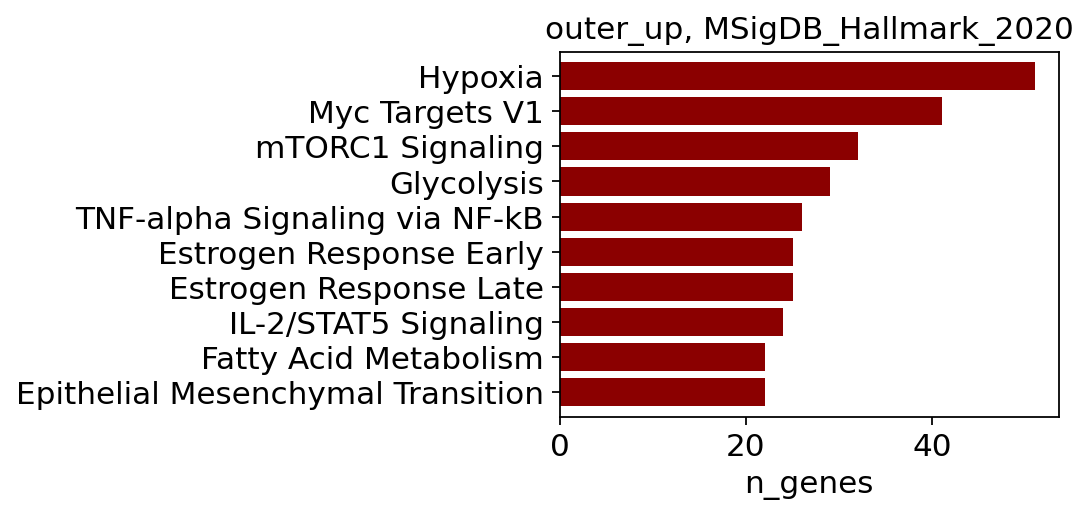

KEGG_2021_Human


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
51,KEGG_2021_Human,Coronavirus disease,75/232,5.292444e-46,7.462346e-44,0,0,11.915091,1242.179626,RPL4;RPL5;NRP1;RPL30;RPL3;RPL32;RPL31;RPL34;RP...,75
50,KEGG_2021_Human,Ribosome,67/158,3.619593e-50,1.020725e-47,0,0,18.236392,2076.083647,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,67
52,KEGG_2021_Human,PI3K-Akt signaling pathway,34/354,6.266453e-06,5.890466e-04,0,0,2.493236,29.869719,YWHAE;CSF1R;CDKN1A;FLT1;HSP90AB1;LAMA3;PDGFB;F...,34
53,KEGG_2021_Human,Focal adhesion,23/201,1.248549e-05,8.802272e-04,0,0,3.013658,34.027046,PDGFRB;PDGFRA;JUN;FLT1;CAV1;LAMA3;PDGFB;VEGFC;...,23
58,KEGG_2021_Human,Proteoglycans in cancer,21/205,1.471541e-04,4.610828e-03,0,0,2.654512,23.423491,CD63;CDKN1A;SDC2;FZD7;CAV1;RPS6;WNT5A;GAB1;HSP...,21
61,KEGG_2021_Human,Rap1 signaling pathway,21/210,2.059371e-04,4.839522e-03,0,0,2.583606,21.929489,PDGFRB;PDGFRA;CSF1R;FLT1;PDGFB;VEGFC;ADCY1;FGF...,21
54,KEGG_2021_Human,Fluid shear stress and atherosclerosis,18/139,2.051106e-05,1.156824e-03,0,0,3.458723,37.335346,MEF2A;GSTM3;JUN;HSP90AA1;HSP90AB1;DUSP1;SDC2;C...,18
60,KEGG_2021_Human,HIF-1 signaling pathway,14/109,1.814432e-04,4.651545e-03,0,0,3.414363,29.413264,EGLN1;CDKN1A;EGLN3;PFKFB3;FLT1;RPS6;SLC2A1;ENO...,14
56,KEGG_2021_Human,Leishmaniasis,12/77,8.013536e-05,3.213107e-03,0,0,4.273678,40.308451,EEF1A1;JUN;MARCKSL1;HLA-DMB;FCGR2A;HLA-DPB1;HL...,12
57,KEGG_2021_Human,Antigen processing and presentation,12/78,9.115197e-05,3.213107e-03,0,0,4.208705,39.153511,CD74;HSP90AA1;HSP90AB1;HLA-DMB;HLA-B;PSME1;HLA...,12


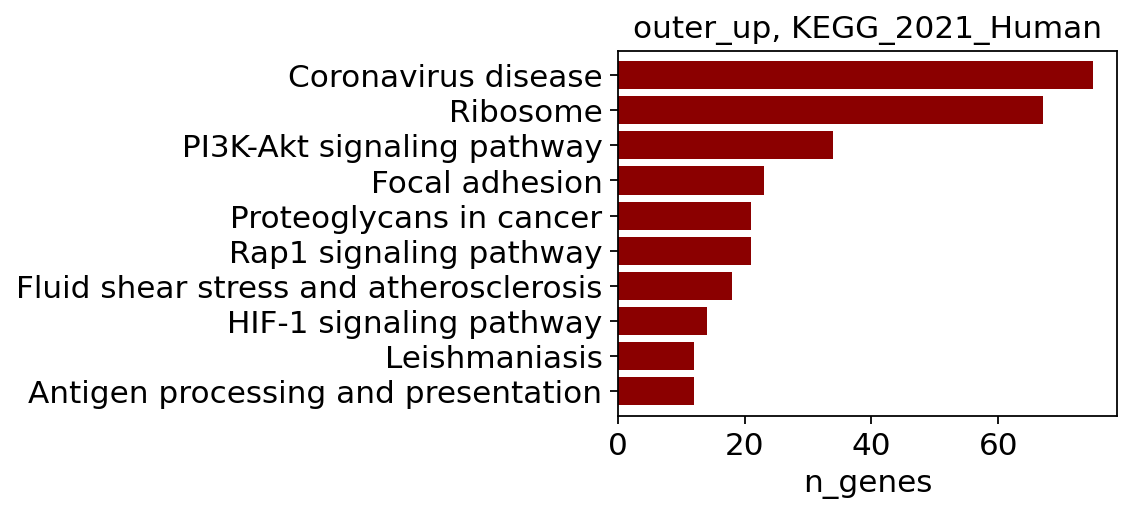

GO_Biological_Process_2023


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
411,GO_Biological_Process_2023,Positive Regulation Of DNA-templated Transcrip...,78/1243,2.171516e-04,8.895074e-03,0,0,1.587637,13.391581,CDKN1C;CSRNP3;CRTC3;KDM1A;CITED2;HMGB2;RORA;YB...,78
375,GO_Biological_Process_2023,Regulation Of Gene Expression (GO:0010468),77/1127,1.484480e-05,1.105600e-03,0,0,1.747746,19.431192,PRDM8;ZNF331;RPL5;MYOM1;CITED2;JADE1;RORA;YBX1...,77
335,GO_Biological_Process_2023,Translation (GO:0006412),71/234,1.755861e-41,1.438489e-38,0,0,10.804274,1013.905768,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,71
345,GO_Biological_Process_2023,Regulation Of Cell Population Proliferation (G...,68/766,3.984989e-09,9.327722e-07,0,0,2.339249,45.242787,CDKN1A;VIPR1;CDCA7L;HILPDA;HMGB2;PTPRK;FGF2;RP...,68
333,GO_Biological_Process_2023,Macromolecule Biosynthetic Process (GO:0009059),68/183,2.451198e-46,4.016288e-43,0,0,14.646509,1538.210583,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,68
336,GO_Biological_Process_2023,Gene Expression (GO:0010467),67/296,1.382105e-30,9.058318e-28,0,0,7.194340,494.639267,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,67
332,GO_Biological_Process_2023,Cytoplasmic Translation (GO:0002181),65/93,3.403945e-68,1.115473e-64,0,0,57.539554,8938.818703,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,65
334,GO_Biological_Process_2023,Peptide Biosynthetic Process (GO:0043043),63/158,3.261919e-45,3.563103e-42,0,0,16.337332,1673.498457,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,63
347,GO_Biological_Process_2023,Regulation Of Apoptotic Process (GO:0042981),62/705,2.819120e-08,5.773910e-06,0,0,2.304199,40.056786,TNFAIP8;CSRNP3;HIP1;CITED2;LGALS1;ADAMTSL4;FAM...,62
338,GO_Biological_Process_2023,Regulation Of Cell Migration (GO:0030334),54/434,7.622215e-13,3.568285e-10,0,0,3.408893,95.116768,SEMA5B;CLIC4;ROBO4;FLT1;CITED2;PTPRK;FGF2;MYLK...,54


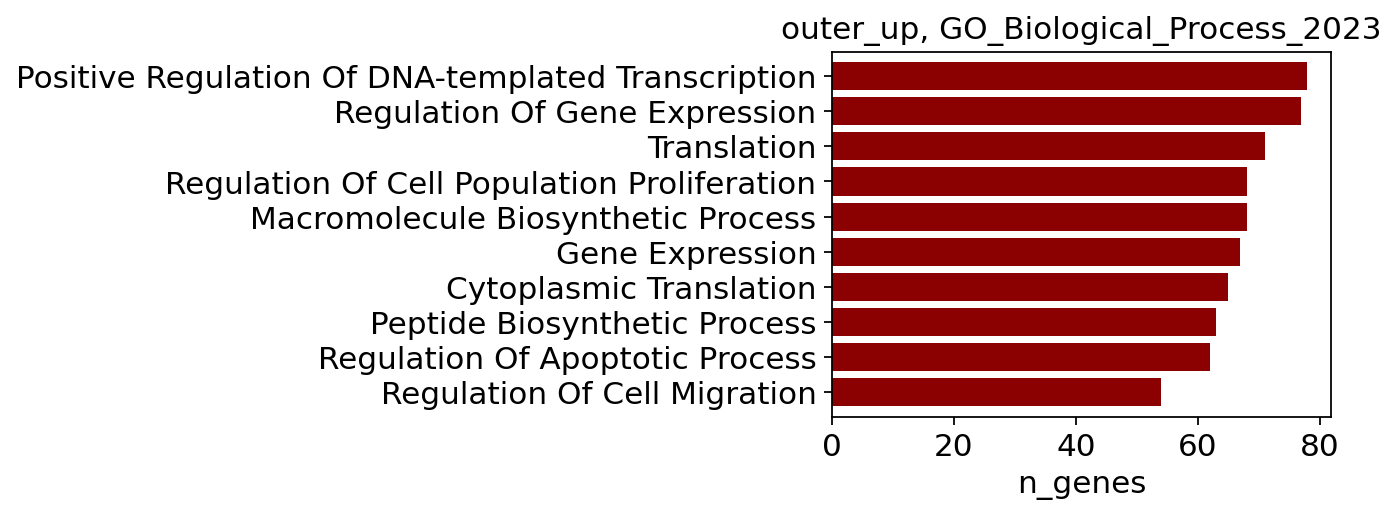


##### middle_up #####
MSigDB_Hallmark_2020


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
0,MSigDB_Hallmark_2020,Myogenesis,15/200,3.230229e-11,1.356696e-09,0,0,11.723370,283.188366,MYOM1;CKM;ACTN2;HSPB8;LDB3;PYGM;SORBS1;ENO3;MY...,15
1,MSigDB_Hallmark_2020,Hypoxia,10/200,2.945719e-06,6.186011e-05,0,0,7.338186,93.452953,GPI;KLF6;UGP2;CSRP2;DPYSL4;PYGM;ENO3;PAM;PFKP;...,10
2,MSigDB_Hallmark_2020,Mitotic Spindle,8/199,1.376213e-04,1.495745e-03,0,0,5.757844,51.193022,TOP2A;CCNB2;CENPF;PRC1;KIF23;EZR;SMC4;VCL,8
3,MSigDB_Hallmark_2020,Oxidative Phosphorylation,8/200,1.424519e-04,1.495745e-03,0,0,5.727564,50.726206,HADHB;GPI;MGST3;ATP5MC2;MFN2;SUCLG1;COX5A;DECR1,8
4,MSigDB_Hallmark_2020,Fatty Acid Metabolism,7/158,2.003507e-04,1.682946e-03,0,0,6.341336,53.999269,HADHB;SUCLG1;CD36;ACSS1;ENO3;GLUL;DECR1,7
5,MSigDB_Hallmark_2020,G2-M Checkpoint,7/200,8.257899e-04,4.954739e-03,0,0,4.950777,35.146410,TOP2A;CCNB2;CENPF;PTTG1;PRC1;KIF23;SMC4,7
6,MSigDB_Hallmark_2020,Adipogenesis,7/200,8.257899e-04,4.954739e-03,0,0,4.950777,35.146410,SCP2;MGST3;HSPB8;SUCLG1;CD36;SORBS1;DECR1,7


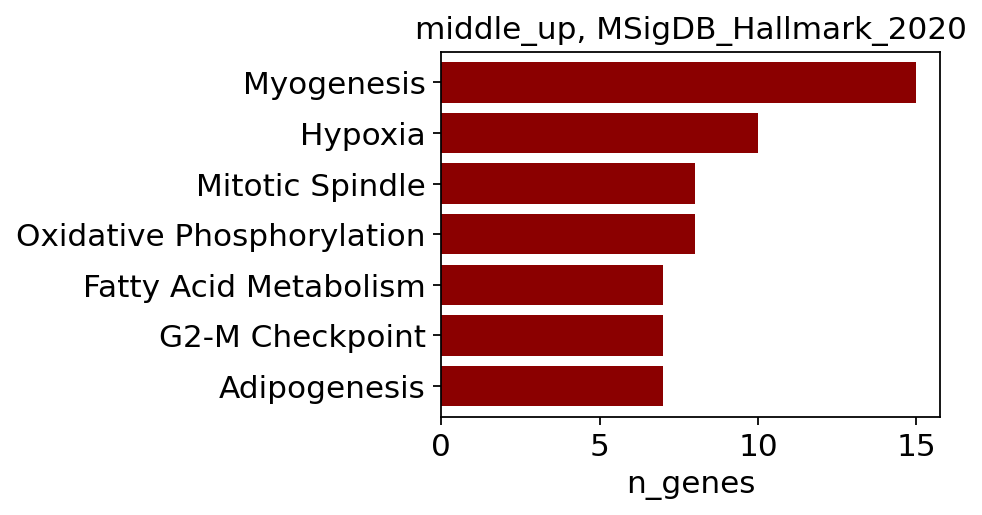

KEGG_2021_Human


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
43,KEGG_2021_Human,Adrenergic signaling in cardiomyocytes,7/150,0.000145,0.009075,0,0,6.698815,59.193224,MYL4;CACNB2;ACTC1;PPP1R1A;TPM1;ATP2A2;ADCY5,7
42,KEGG_2021_Human,Cardiac muscle contraction,6/87,0.000051,0.009075,0,0,10.098595,99.777226,MYL4;CACNB2;ACTC1;TPM1;ATP2A2;COX5A,6
44,KEGG_2021_Human,Glycolysis / Gluconeogenesis,5/67,0.000152,0.009075,0,0,10.929629,96.082756,GPI;ALDH3B1;ACSS1;ENO3;PFKP,5


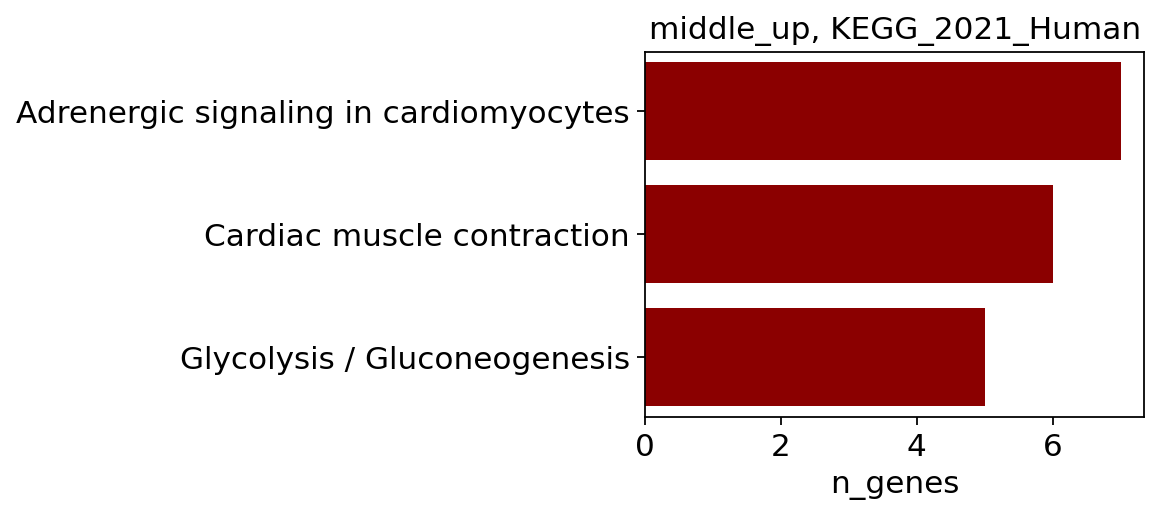

GO_Biological_Process_2023


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
223,GO_Biological_Process_2023,Regulation Of Cold-Induced Thermogenesis (GO:0...,8/146,0.000015,0.006199,0,0,7.990676,88.581659,OXTR;FABP5;PLCL1;ACOT13;MFN2;CD36;IGF1R;DECR1,8
222,GO_Biological_Process_2023,Actomyosin Structure Organization (GO:0031032),7/77,0.000002,0.001140,0,0,13.735417,181.094728,CSRP2;ACTN2;TPM1;TNNT3;ANKRD1;PHACTR1;SORBS1,7
221,GO_Biological_Process_2023,Myofibril Assembly (GO:0030239),6/46,0.000001,0.001140,0,0,20.492069,278.967912,CSRP2;ADPRHL1;ACTN2;TPM1;TNNT3;ANKRD1,6


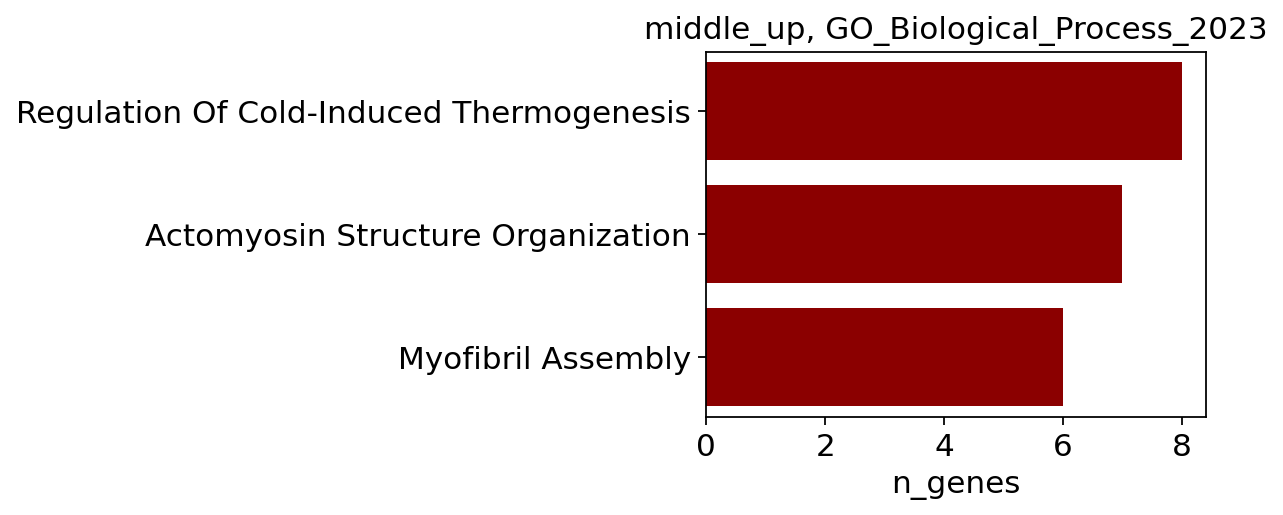


##### inner_up #####
MSigDB_Hallmark_2020


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
0,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,79/200,7.928112e-23,3.964056e-21,0,0,4.806260,244.585956,ITGB1;SPARC;ECM2;COL16A1;ITGB5;ELN;COL12A1;TNC...,79
1,MSigDB_Hallmark_2020,Myogenesis,72/200,2.934618e-18,7.336546e-17,0,0,4.126974,166.605739,EIF4A2;ITGB1;APP;SPARC;ITGB5;FHL1;COX6A2;CLU;M...,72
2,MSigDB_Hallmark_2020,Apical Junction,54/200,1.066313e-08,1.777188e-07,0,0,2.690433,49.386859,ITGB1;COL16A1;IRS1;PKD1;TRO;SPEG;NRTN;LDLRAP1;...,54
7,MSigDB_Hallmark_2020,Adipogenesis,44/200,7.080491e-05,4.425307e-04,0,0,2.041967,19.512181,PHLDB1;RNF11;MGST3;LAMA4;LPL;UQCR11;UQCR10;COX...,44
8,MSigDB_Hallmark_2020,Oxidative Phosphorylation,43/200,1.472479e-04,8.180440e-04,0,0,1.981909,17.487163,MTRR;NDUFB6;MGST3;MRPS11;NDUFB4;COX17;TIMM13;N...,43
3,MSigDB_Hallmark_2020,UV Response Dn,41/144,1.262372e-07,1.577964e-06,0,0,2.886998,45.860258,IRS1;CELF2;COL11A1;FHL2;ICA1;PIK3R3;PTPRM;PTPN...,41
5,MSigDB_Hallmark_2020,Apoptosis,39/161,1.878679e-05,1.565565e-04,0,0,2.314039,25.182194,IFITM3;APP;HSPB1;NEDD9;CLU;SAT1;ADD1;LGALS3;RH...,39
12,MSigDB_Hallmark_2020,Mitotic Spindle,39/199,1.886090e-03,7.254191e-03,0,0,1.760608,11.044733,STAU1;NEDD9;KLC1;PKD2;HDAC6;CDC42;PREX1;ABR;RH...,39
6,MSigDB_Hallmark_2020,Coagulation,34/138,4.331229e-05,3.093735e-04,0,0,2.364062,23.751903,ARF4;SPARC;CFH;WDR1;USP11;HTRA1;FURIN;CRIP2;CL...,34
4,MSigDB_Hallmark_2020,Unfolded Protein Response,33/113,1.106276e-06,1.106276e-05,0,0,2.985755,40.948169,EIF4A2;EIF4A1;CEBPB;SHC1;FKBP14;GOSR2;CXXC1;SL...,33


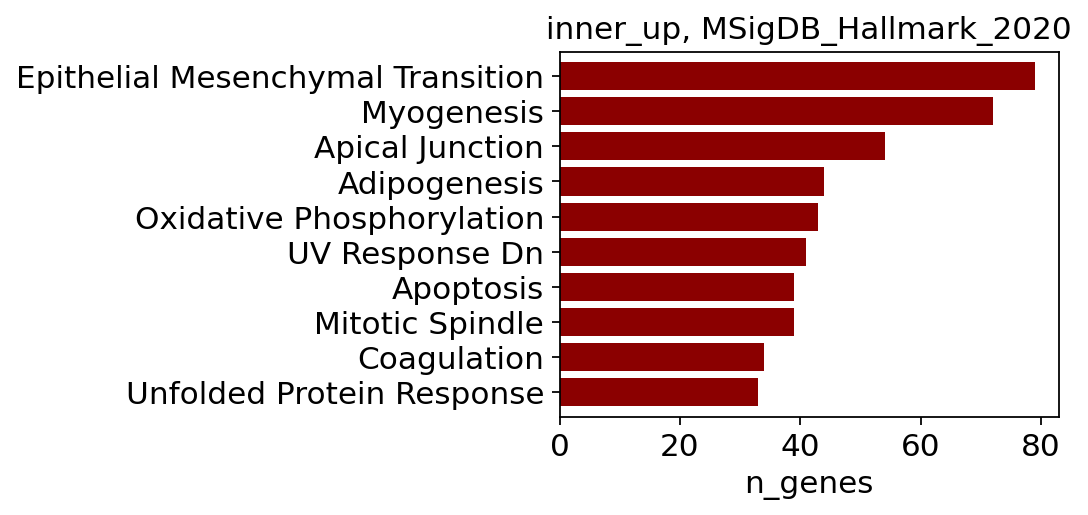

KEGG_2021_Human


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
86,KEGG_2021_Human,Pathways in cancer,89/531,1.201841e-03,9.910771e-03,0,0,1.461165,9.824730,ITGB1;LAMC3;KEAP1;LAMC1;IKBKB;EDNRA;MECOM;CCND...,89
56,KEGG_2021_Human,PI3K-Akt signaling pathway,75/354,1.163318e-06,5.135218e-05,0,0,1.957651,26.749803,CHRM2;ITGB1;ITGB5;IRS1;LAMC3;TNC;LAMC1;IKBKB;G...,75
55,KEGG_2021_Human,Human papillomavirus infection,72/331,6.768322e-07,3.485686e-05,0,0,2.024252,28.756205,ITGB1;ITGB5;MAML1;LAMC3;TNC;LAMC1;IKBKB;LFNG;C...,72
51,KEGG_2021_Human,Focal adhesion,61/201,6.339093e-12,9.793899e-10,0,0,3.179838,81.989844,ITGB1;ITGB5;LAMC3;TNC;ILK;LAMC1;MYLK3;PPP1CB;C...,61
83,KEGG_2021_Human,Huntington disease,57/306,7.569982e-04,6.879778e-03,0,0,1.657388,11.910236,NDUFA11;NDUFA12;COX6A1;AP2A2;COX6A2;TUBB6;ACTR...,57
50,KEGG_2021_Human,Protein processing in endoplasmic reticulum,55/171,5.393605e-12,9.793899e-10,0,0,3.456331,89.677291,TRAM1;PRKCSH;HERPUD1;SEC61A2;SEC61A1;MAN1A1;SE...,55
73,KEGG_2021_Human,Prion disease,55/273,1.229979e-04,1.583598e-03,0,0,1.828390,16.461623,NDUFA11;NDUFA12;LAMC1;COX6A1;COX6A2;TUBB6;PSMD...,55
60,KEGG_2021_Human,Parkinson disease,55/249,8.394312e-06,2.358039e-04,0,0,2.057427,24.047120,NDUFA11;NDUFA12;COX6A1;COX6A2;TUBB6;PSMD4;PSMD...,55
64,KEGG_2021_Human,Endocytosis,54/252,2.495374e-05,5.140470e-04,0,0,1.977928,20.963045,VPS29;ARF4;ARF1;ARPC1A;ARPC5L;WASHC2C;AP2A2;ZF...,54
57,KEGG_2021_Human,Regulation of actin cytoskeleton,51/218,3.173795e-06,1.225878e-04,0,0,2.215984,28.055645,CHRM2;ITGB1;ITGB5;ARPC1A;ARPC5L;ITGAE;MYLK3;PP...,51


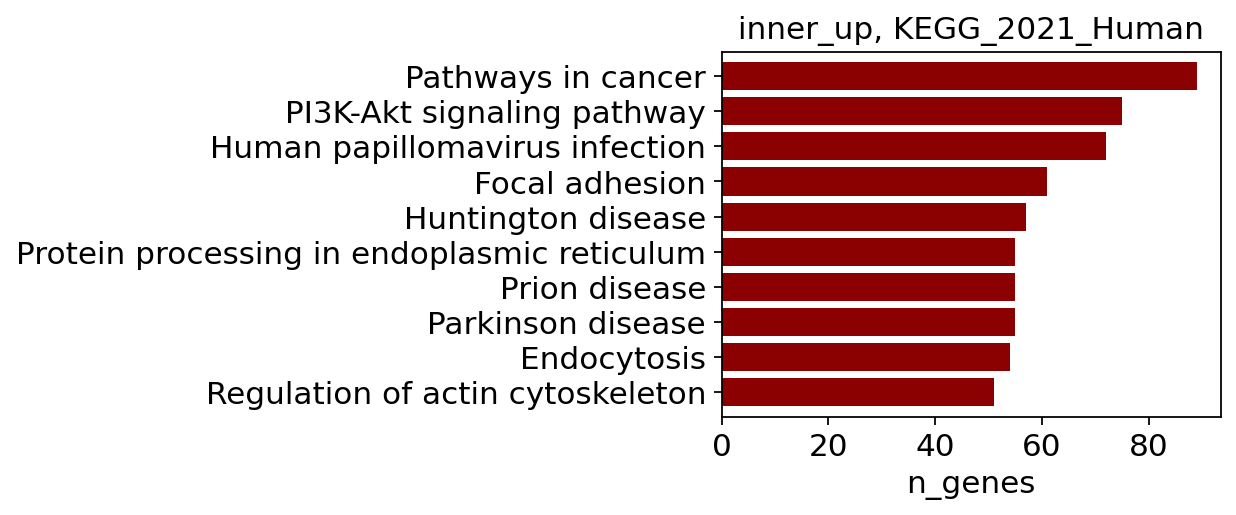

GO_Biological_Process_2023


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
380,GO_Biological_Process_2023,Regulation Of Cell Migration (GO:0030334),86/434,3.607719e-06,7.233084e-04,0,0,1.800851,22.569054,SEMA5A;ITGB1;PLXND1;FAM89B;ULK4;TNC;CIB1;ADARB...,86
365,GO_Biological_Process_2023,Proteasome-Mediated Ubiquitin-Dependent Protei...,73/319,6.922768e-08,4.025556e-05,0,0,2.163360,35.664864,AUP1;HERPUD1;CLGN;ANKRD9;KAT5;PSMD4;TRIM2;PSMD...,73
371,GO_Biological_Process_2023,Supramolecular Fiber Organization (GO:0097435),71/316,2.215832e-07,7.607122e-05,0,0,2.111022,32.346063,APP;COL18A1;COL14A1;AVIL;COL12A1;PLOD3;CIB1;LM...,71
410,GO_Biological_Process_2023,Ubiquitin-Dependent Protein Catabolic Process ...,70/367,9.789929e-05,8.402395e-03,0,0,1.711010,15.795310,RNF11;RNF13;RNF14;TGFB1I1;KEAP1;UBE3B;HERPUD1;...,70
384,GO_Biological_Process_2023,Regulation Of Autophagy (GO:0010506),54/241,6.507172e-06,1.116981e-03,0,0,2.095604,25.026974,VPS29;CISD2;KEAP1;HSPB1;HMGB1;TRIM8;CAPNS1;KAT...,54
359,GO_Biological_Process_2023,Extracellular Matrix Organization (GO:0030198),54/176,6.403327e-11,2.857805e-07,0,0,3.224137,75.675721,APP;COL18A1;COL16A1;ECM2;COL14A1;ELN;COL12A1;P...,54
360,GO_Biological_Process_2023,Heart Development (GO:0007507),50/171,2.046047e-09,4.565753e-06,0,0,3.005134,60.124783,TCF25;ECE1;PKD2;PKD1;SALL1;SGCD;GJA5;PLCE1;BVE...,50
383,GO_Biological_Process_2023,Regulation Of Angiogenesis (GO:0045765),48/205,5.948522e-06,1.061930e-03,0,0,2.216975,26.675455,SEMA5A;ITGB1;FOXC1;GRN;SP100;RNH1;SPARC;BTG1;P...,48
400,GO_Biological_Process_2023,"mRNA Splicing, Via Spliceosome (GO:0000398)",46/211,6.203694e-05,6.493071e-03,0,0,2.018977,19.559406,SF3B4;ISY1;DDX5;RBM8A;DHX9;RNPC3;PNN;PUF60;SNR...,46
397,GO_Biological_Process_2023,Actin Filament Organization (GO:0007015),35/144,4.560745e-05,5.219129e-03,0,0,2.322257,23.211982,AVIL;NEDD9;CNN3;LMOD2;EPS8;CNN2;CDC42;CNN1;NRA...,35


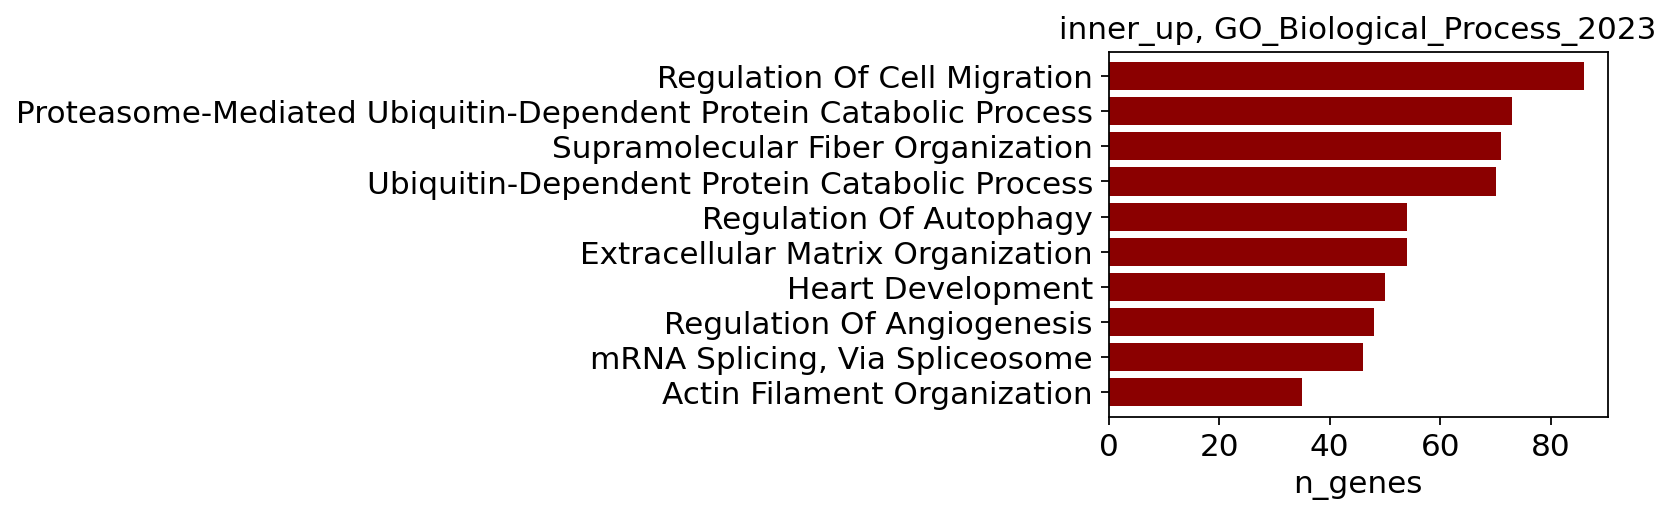

In [28]:
import gseapy as gp
pd.set_option('display.max_rows', None)

geneset_list = ['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Biological_Process_2023']
key_to_sort = 'n_genes'
n_rank = 10

enr_res = {}
for key in gene_lists.keys():
    if ('up' in key) & (len(gene_lists[key])>0):
        print(f'##### {key} #####')

        enr_res[key] = gp.enrichr(gene_list=gene_lists[key],
                         gene_sets=geneset_list,
                         organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                         outdir=None, # don't write to disk
                        )

        for geneset in geneset_list:
            print(geneset)
            df = enr_res[key].results[enr_res[key].results['Gene_set'] == geneset]
            df = df[df['Adjusted P-value'] < 0.01]
            df['n_genes'] = [int(x.split('/')[0]) for x in df['Overlap']]
            df = df.sort_values(key_to_sort,ascending=False)
            # df = df.sort_values('Combined Score',ascending=False)
            display(df)

            # plot
            df = df[df['Adjusted P-value'] < 0.01]
            plt.rcParams['axes.grid'] = False
            plt.rcParams['figure.figsize'] = 4,3
            plt.barh(width=df[:n_rank][key_to_sort],
                     y=[x.split(' (')[0] for x in df[:n_rank]['Term']],
                     color='darkred')
            plt.gca().invert_yaxis()
            plt.xlabel(key_to_sort)
            plt.title(f'{key}, {geneset}')
            plt.margins(y=0.03)
            plt.savefig(f'{figdir}/tm-axis_pathways_{key}_{geneset}.pdf', bbox_inches="tight",dpi=300)
            plt.show()

        print('')

# Plot genes

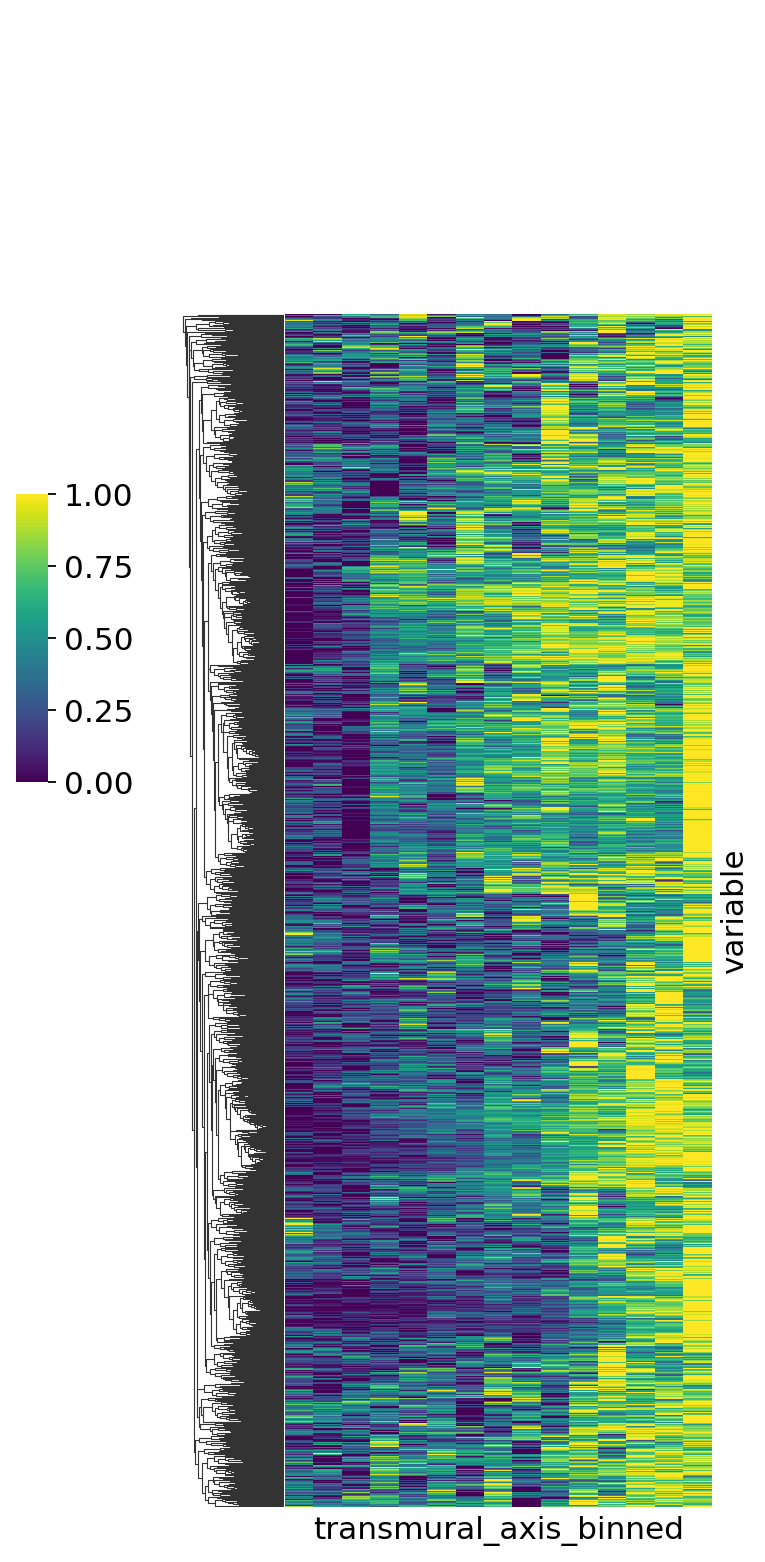

In [25]:
key = 'inner_up'
hight = 10

tissueaxis.plot_axis(adata_oct,
              axis_col='transmural_axis',
              n_bin=15,
              feature_type='gene', # 'gene' or 'celltype'
              features_to_plot=gene_lists[key],
              features_to_remove=None,
              threshold_express_prop=None, # at quantile=0.9
              threshold_cell_abundance=None, # at quantile=0.9
              correlation=False,
              min_max_scale=True,
              row_cluster=True,
              figsize=(4,hight),
              cbar_pos=(-0.2, 0.5, 0.05, 0.18),
              cmap='viridis',
          xticklabels=False,
          yticklabels=False,
              title=None,
              return_feature = False,
                     save=f'{figdir}/tm-axis_OCT_genes_{key}.pdf',
    save_dpi=300,
             )

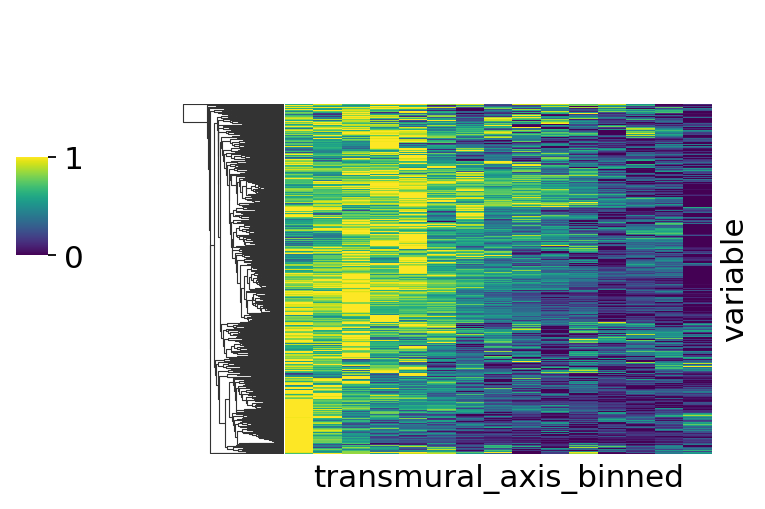

In [27]:
key = 'outer_up'
hight = 10 * len(gene_lists['outer_up'])/len(gene_lists['inner_up'])

tissueaxis.plot_axis(adata_oct,
              axis_col='transmural_axis',
              n_bin=15,
              feature_type='gene', # 'gene' or 'celltype'
              features_to_plot=gene_lists[key],
              features_to_remove=None,
              threshold_express_prop=None, # at quantile=0.9
              threshold_cell_abundance=None, # at quantile=0.9
              correlation=False,
              min_max_scale=True,
              row_cluster=True,
              figsize=(4,hight),
              cbar_pos=(-0.2, 0.5, 0.05, 0.18),
              cmap='viridis',
          xticklabels=False,
          yticklabels=False,
              title=None,
              return_feature = False,
                     save=f'{figdir}/tm-axis_OCT_genes_{key}.pdf',
    save_dpi=300,
             )

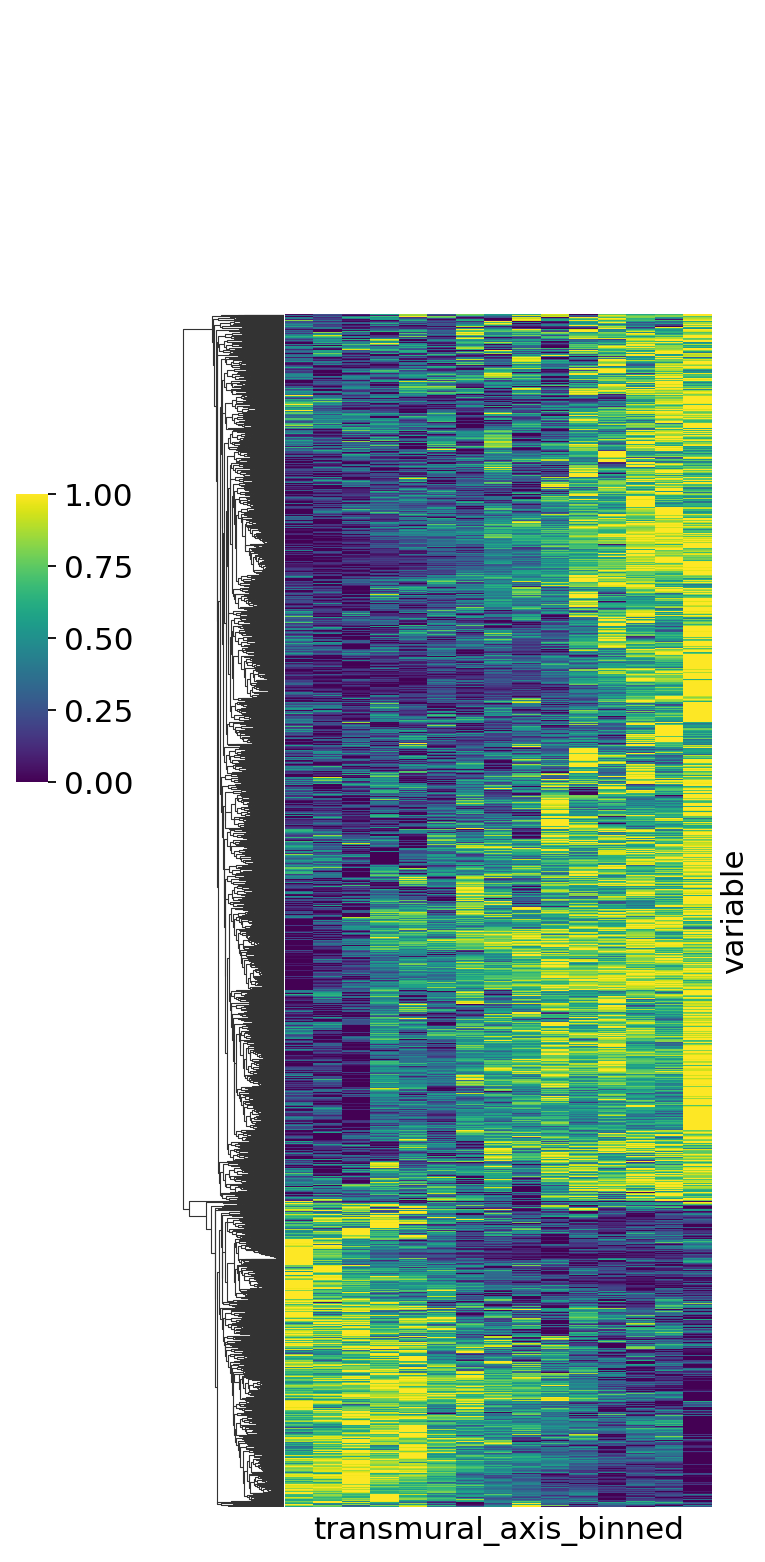

In [119]:
tissueaxis.plot_axis(adata_oct,
              axis_col='transmural_axis',
              n_bin=15,
              feature_type='gene', # 'gene' or 'celltype'
              features_to_plot=gene_lists[f'inner_up']+gene_lists[f'outer_up'],
              features_to_remove=None,
              threshold_express_prop=None, # at quantile=0.9
              threshold_cell_abundance=None, # at quantile=0.9
              correlation=False,
              min_max_scale=True,
              row_cluster=True,
              figsize=(4,10),
              cbar_pos=(-0.2, 0.5, 0.05, 0.18),
              cmap='viridis',
          xticklabels=False,
          yticklabels=False,
              title=None,
              return_feature = False,
                     save=f'{figdir}/tm-axis_OCT_genes.pdf',
    save_dpi=300,
             )